# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
  1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
  1.0
  1.0
 -1.0

### We create a function to visualize the data

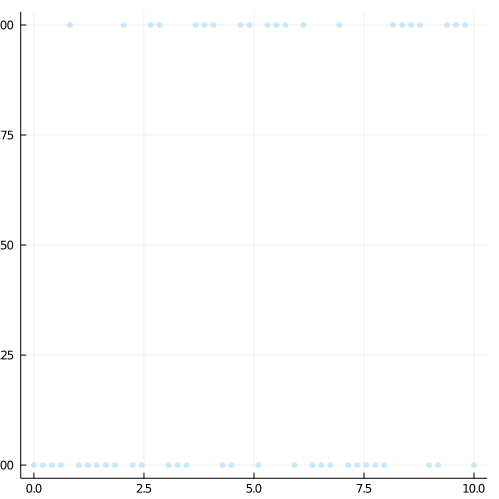

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.505743 seconds (1.15 M allocations: 67.506 MiB, 99.26% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:04:13
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:08
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:25
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:04
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:00:51
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:36
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:31
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:28
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:25
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:23
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:21
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.626187678159408, -1.6118249185872409, -1.5821192938371742, -1.5505776895682934, -1.529397193926326, -1.458101785348934, -1.377370843473163, -1.2641743451477396, -1.0781656488698383, -0.8732054287175696  …  -0.17331919829727926, 0.3105559771949419, 0.6820428409511916, 0.9409903657086657, 1.0327820565469308, 0.9581519248285777, 0.7581020256626656, 0.5134401633151314, 0.2683156444872956, 0.08622590484106255]]
 [[-1.761167072855065, -1.708419469222407, -1.5992804512821233, -1.4513516926171914, -1.3421982380410937, -1.2872671778514957, -1.3249577225176836, -1.384153021037972, -1.444442495290344, -1.424863633279223  …  -0.026270802741459105, 0.18992498689382148, 0.37775319051529, 0.5349513065995766, 0.6018787351156412, 0.5930722968217146, 0.5106363021107927, 0.35721706921280627, 0.21852734340408142, 0.0957133840687959]]
 [[-1.8348622550259504, -2.154969833226775, -2.248341999239019, -2.1738697435122734, -1.943627019492781, -1.61517235214219

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

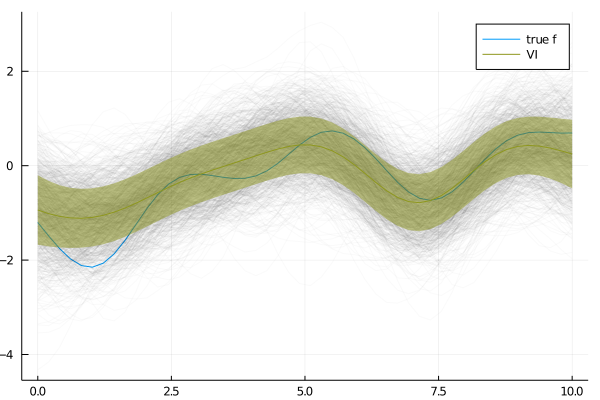

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

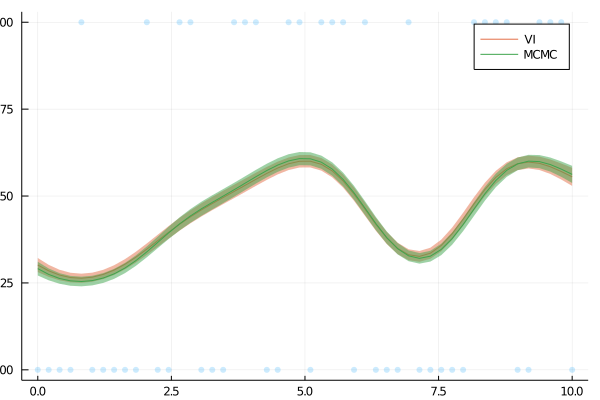

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*